### imports first

In [1]:
from __future__ import division
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np 
#sys.path.append("../tools/")
import feature_format
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, load_classifier_and_data, dump_classifier_and_data
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

### Task 1: Select what features you'll use.

In [2]:
### Task 1: Select what features you'll use

financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', \
                     'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', \
                     'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', \
                     'director_fees']

email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', \
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] 

poi_label = ['poi']

all_features =  poi_label + financial_features + email_features



In [3]:
# Determining the number of POI's
poi_count = 0
for key, value in data_dict.items():
    if value['poi']:
        poi_count+=1
total_dataset_features = []



In [4]:
# Validate that all features are contained in feature list and data dict
for k,v in data_dict.items():
    for i in v:
        if i not in total_dataset_features:
            total_dataset_features.append(i)



In [5]:

print(f'There are {len(total_dataset_features)} unique columns in the data dictionary')
print(f'There are {len(all_features)} total features in my list')

# Distribution of POI/non-POI
print(f'There are {poi_count} POIs')
print(f'There are {len(data_dict)} people in this dataset')
print('This dataset has an imbalanced y distribution')



There are 21 unique columns in the data dictionary
There are 21 total features in my list
There are 18 POIs
There are 146 people in this dataset
This dataset has an imbalanced y distribution


Text(0.5, 1.0, 'Missing Values (NaNs) per Feature')

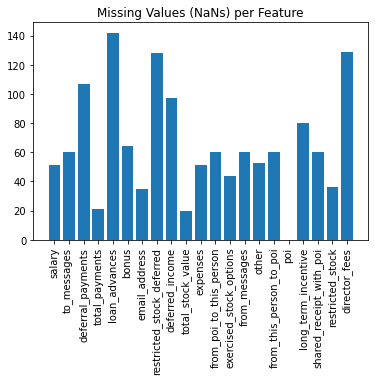

In [6]:
# Let's see where those missing values are at
nans_count = {}
for i in all_features:
    nans_count[i] = 0

missing_values = {}
for k,v in data_dict.items():
    for k2, v2 in v.items(): 
        if k2 not in missing_values:
            missing_values[k2] = 0
        if v2 == 'NaN':
            missing_values[k2] += 1
            nans_count[k2]+=1
plt.bar(missing_values.keys(), missing_values.values())
plt.xticks(rotation=90)
plt.title('Missing Values (NaNs) per Feature')



In [7]:
features_to_remove = []
for k,v in missing_values.items():
    if v/len(data_dict) > .9:
        features_to_remove.append(k)        

### Task 2: Remove Outliers

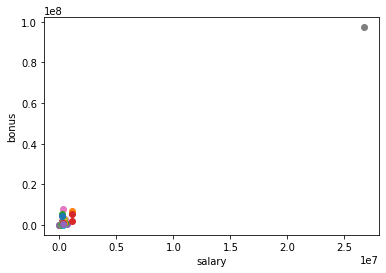

None


In [8]:
### Task 2: Remove outliers

### Function to plot 2 dimensions
def Plot_2dimension(data_dict, feature_x, feature_y):
    data = featureFormat(data_dict, [feature_x, feature_y])
    #for point in data:
        #x = point[0]
        #y = point[1]
        #plt.scatter(x, y)
    for i in data:
        salary = i[0]
        bonus = i[1]
        plt.scatter(salary, bonus)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

### Visualise outliers by 2 dimension ploting
print(Plot_2dimension(data_dict, 'salary', 'bonus'))

In [9]:
features_to_artificially_alter = ["salary", "bonus"]

data = feature_format.featureFormat(data_dict, features_to_artificially_alter)

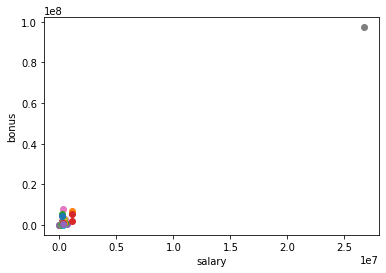

In [10]:
for i in data:
    salary = i[0]
    bonus = i[1]
    plt.scatter(salary, bonus)
    
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()
outlier = data.max()

In [11]:
# Find the key that is the outlier
for k,v in data_dict.items():
    if str(int(outlier)) in str(v):
        outlier_key = k

In [12]:
# The outlier is 'TOTAL'
data_dict.pop(outlier_key)

{'salary': 26704229,
 'to_messages': 'NaN',
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 'NaN',
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 311764000,
 'from_messages': 'NaN',
 'other': 42667589,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 130322299,
 'director_fees': 1398517}

In [13]:
## Let's get rid of travel agency and steamrolling errors
## added removal of Lockhart Eugene E for NaNs on second commit
try:
    data_dict.pop('THE TRAVEL AGENCY IN THE PARK')
    print('Travel agency entry removed from dictionary')
except:
    print('Travel agency not contained in dictionary')
    print('But it was just there a minute ago?')
    pass
try:
    data_dict.pop('LOCKHART EUGENE E')
    print('LOCKHART EUGENE E removed from dictionary')
except:
    print('LOCKHART EUGENE E not contained in dictionary')
    print('But it was just there a minute ago?')
    pass

Travel agency entry removed from dictionary
LOCKHART EUGENE E removed from dictionary


In [14]:
keys_to_remove = []
for persons_name, features_dict in data_dict.items():
    nan_count = 0
    for features_dict_key, feature_value in features_dict.items():
        if feature_value == 'NaN':
            nan_count += 1
    if nan_count >= len(features_dict) * .5:
        print(f'{persons_name} is missing values for over 85% of all features')
        keys_to_remove.append(persons_name)

CORDES WILLIAM R is missing values for over 85% of all features
MORDAUNT KRISTINA M is missing values for over 85% of all features
NOLES JAMES L is missing values for over 85% of all features
LOWRY CHARLES P is missing values for over 85% of all features
WESTFAHL RICHARD K is missing values for over 85% of all features
WALTERS GARETH W is missing values for over 85% of all features
CHAN RONNIE is missing values for over 85% of all features
BELFER ROBERT is missing values for over 85% of all features
WODRASKA JOHN is missing values for over 85% of all features
URQUHART JOHN A is missing values for over 85% of all features
WHALEY DAVID A is missing values for over 85% of all features
MENDELSOHN JOHN is missing values for over 85% of all features
CLINE KENNETH W is missing values for over 85% of all features
LEWIS RICHARD is missing values for over 85% of all features
KOPPER MICHAEL J is missing values for over 85% of all features
BERBERIAN DAVID is missing values for over 85% of all feat

In [15]:
for i in keys_to_remove:
    data_dict.pop(i)
    
print(f'Will remove {features_to_remove} features')

Will remove ['loan_advances'] features


In [16]:
### Create list of outliers based on dimension salary
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key,int(val)))

In [17]:
### Sort the list of outliers and print the top 1 outlier in the list
#print ('Outliers in terms of salary: ')
#pprint(sorted(outliers,key=lambda x:x[1],reverse=True)[:1])

In [18]:
### Sort the list of outliers and print the top 3 outliers in the list
print ('Outliers in terms of salary: ')
pprint(sorted(outliers,key=lambda x:x[1],reverse=True)[0:3])

Outliers in terms of salary: 
[('SKILLING JEFFREY K', 1111258),
 ('LAY KENNETH L', 1072321),
 ('FREVERT MARK A', 1060932)]


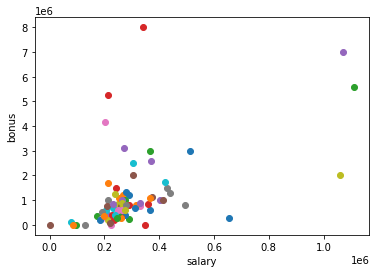

None


In [19]:
### Visualise outliers by 2 dimension ploting
### lets see it again
print(Plot_2dimension(data_dict, 'salary', 'bonus'))

### Task 3: Create new feature(s)

In [20]:
### Task 3: Create new feature(s)

my_dataset = data_dict

features_list = []

In [21]:
# iterate thru
for i in my_dataset:
    # let's see how big their bonus was compared to their salary 
    try:
        my_dataset[i]['bonus_ratio'] = float(my_dataset[i]['bonus']) / float(my_dataset[i]['salary'])
    except:
        pass
        #my_dataset[i]['bonus_ratio'] = 0.0
    # Let's see how big their expenses are compared to their pay.
    try:
        my_dataset[i]['bonus_total_ratio'] = float(my_dataset[i]['bonus']) / float(my_dataset[i]['total_payments'])
    except:
        pass
        #my_dataset[i]['bonus_total_ratio'] = 0.0
    # Let's see how many emails they sent to unsavory folk

    try:
        my_dataset[i]['emails_to_crooks_ratio'] = my_dataset[i]['from_this_person_to_poi'] / my_dataset[i]['to_messages']
    except:
        pass
        #my_dataset[i]['emails_to_crooks_ratio'] = 0.0
    # Same ratio, but different. But still the same.
    try:
        my_dataset[i]['emails_from_crooks_ratio'] = my_dataset[i]['from_messages'] / my_dataset[i]['from_poi_to_this_person']
    except:
        pass
        #my_dataset[i]['emails_from_crooks_ratio'] = 0.0
    try:
        my_dataset[i]['poi_message_percent'] = (my_dataset[i]['from_this_person_to_poi'] + my_dataset[i]['from_poi_to_this_person'])/(my_dataset[i]['to_messages']+my_dataset[i]['from_messages'])
    except:
        pass
        #my_dataset[i]['poi_message_percent'] = 0.0

new_features = ['bonus_total_ratio', 'bonus_ratio', 'emails_to_crooks_ratio','emails_from_crooks_ratio','poi_message_percent']
        

In [22]:
### Extract features and labels from dataset for "local" testing
df = pd.DataFrame.from_dict(my_dataset).T
df = df.apply(pd.to_numeric, errors='coerce')
df['poi'] = df['poi'].astype('int')
df.drop('email_address', axis=1, inplace=True)
df.drop('director_fees', axis=1, inplace=True)
df.drop('restricted_stock_deferred', axis=1, inplace=True)
df.drop('loan_advances', axis=1, inplace=True)

In [23]:
#for i in features_to_remove:
    #try:
        #df.drop(i, axis=1, inplace=True)
        #all_features.remove(i)
        #print(i, 'was removed')
    #except:
     #   pass

In [24]:
df.fillna(0, axis=1, inplace=True)
#for i in df:
#    df.fillna(value=df[i].mean(), axis=1, inplace=True)
all_features = [x for x in df.columns]
my_dataset = df.T.to_dict()

In [25]:
print(f'Number of features used: {len(all_features)}')
print(all_features)

Number of features used: 22
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'bonus_ratio', 'bonus_total_ratio', 'emails_to_crooks_ratio', 'emails_from_crooks_ratio', 'poi_message_percent']


### Task 4: Try a variety of classifiers

In [26]:
### Task 4: Try a variety of classifiers

data = featureFormat(my_dataset, all_features, sort_keys = True)

In [27]:
# features is x and labels is y
# label_train, feature_train
labels, features = targetFeatureSplit(data)

In [28]:
f_values = f_classif(features, labels)

significant_count = 0
significant_idx = []
print('P-values:')
for i in range(f_values[0].shape[0]):
    if f_values[1][i] < .05:
        significant_count += 1
        significant_idx.append((i, f_values[1][i]))
#print(f'Significant Features: {str(significant_idx).replace("[","").replace("]","")} ')
print(f'There are {significant_count} significant features')
print('I will use these 17 most significant features in my analysis')

significant_idx_sorted = sorted(significant_idx, key=lambda tup: tup[1])

for i in significant_idx_sorted:
    print(f'{df.columns.to_list()[i[0]]} p-value: {i[1]}')

P-values:
There are 17 significant features
I will use these 17 most significant features in my analysis
from_messages p-value: 2.825974283191731e-10
other p-value: 7.851149274933987e-09
total_payments p-value: 6.005579219005083e-07
bonus p-value: 7.786626459584136e-07
restricted_stock p-value: 2.1399194002331082e-06
bonus_total_ratio p-value: 7.492453765079175e-06
bonus_ratio p-value: 1.473270071002223e-05
total_stock_value p-value: 3.2414186203140057e-05
exercised_stock_options p-value: 6.653373711062176e-05
emails_to_crooks_ratio p-value: 0.0001122187237472138
expenses p-value: 0.00014871497285688252
salary p-value: 0.0008301592233076298
long_term_incentive p-value: 0.002917201448582638
deferred_income p-value: 0.0032911361893383554
from_poi_to_this_person p-value: 0.003643596368428283
poi p-value: 0.0038886339013330055
deferral_payments p-value: 0.014783917631923413


In [29]:
# To increase f1 of my models, I will only use the k(17) best features from here out
selector = SelectKBest(f_classif, k = 17)
selector.fit_transform(features, labels)
scores = sorted(zip(all_features[1:], selector.scores_), key = lambda x: x[1], reverse=True)
best_features = list(map(lambda x: x[0], scores))[0:14]
best_features_list = poi_label + best_features

In [30]:
#use the best features as chosen by SelectKbest
data = featureFormat(my_dataset, best_features_list)

labels, features = targetFeatureSplit(data)

In [31]:
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, random_state=42)
    
sss = StratifiedShuffleSplit(n_splits= 100, test_size= 0.3, random_state= 42)
sss.get_n_splits(features, labels)

100

In [32]:
### here's where we actually try the variety of classifiers

#gaussian NB
g_clf = GaussianNB()
g_clf.fit(features_train, labels_train)
g_pred = g_clf.predict(features_test)

print("############################################")
print("Precision score_Gaussian is:", precision_score(labels_test, g_pred, average = 'macro', zero_division = 0))
print("Recall score_Gaussian is: ", recall_score(labels_test, g_pred, average = 'macro', zero_division = 0))

############################################
Precision score_Gaussian is: 0.45
Recall score_Gaussian is:  0.45


In [33]:
#Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(features_train, labels_train)
dt_pred = dt_clf.predict(features_test)

print("############################################")
print("Precision score_DecisionTree is:", precision_score(labels_test, dt_pred, average = 'macro', zero_division = 0))
print("Recall score_DecisionTree is: ", recall_score(labels_test, dt_pred, average = 'macro', zero_division = 0))

############################################
Precision score_DecisionTree is: 0.6403508771929824
Recall score_DecisionTree is:  0.7


In [34]:
#Kneighbors
knn_clf = KNeighborsClassifier()
knn_clf.fit(features_train, labels_train)
knn_pred = knn_clf.predict(features_test)

print("############################################")
print("Precision score_KNN is:", precision_score(labels_test, knn_pred, average = 'macro', zero_division = 0))
print("Recall score_KNN is: ", recall_score(labels_test, knn_pred, average = 'macro', zero_division = 0))


############################################
Precision score_KNN is: 0.45454545454545453
Recall score_KNN is:  0.5


In [35]:
#SVC
svc_clf = SVC(probability=False)
svc_clf.fit(features_train, labels_train)
svc_pred = svc_clf.predict(features_test)

print("############################################")
print("Precision score_SVC is:", precision_score(labels_test, svc_pred, average = 'macro', zero_division = 0))
print("Recall score_SVC is: ", recall_score(labels_test, svc_pred, average = 'macro', zero_division = 0))

############################################
Precision score_SVC is: 0.45454545454545453
Recall score_SVC is:  0.5


In [36]:
#adaboost
ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(features_train, labels_train)
ada_pred = ada_clf.predict(features_test)

print("############################################")
print("Precision score_ADA is:", precision_score(labels_test, ada_pred, average = 'macro', zero_division = 0))
print("Recall score_ADA is: ", recall_score(labels_test, ada_pred, average = 'macro', zero_division = 0))

############################################
Precision score_ADA is: 0.45
Recall score_ADA is:  0.45


In [37]:
ada_clf.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

Attempting tuning with scaling. using pipelines, applying MinMaxScaler() and PCA.

In [38]:
sss = StratifiedShuffleSplit(n_splits= 100, test_size= 0.3, random_state= 42)
scoring = 'f1'
skb = SelectKBest(f_classif)

In [39]:
scaler = MinMaxScaler()
pca = PCA()

In [40]:
g_clf = GaussianNB()   

g_pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca),('skb', skb), ('gaussian', g_clf)])

g_params = dict(pca__n_components=[4,5,6,7,8,9,10],
                    skb__k = [1,2,3,4])

In [41]:
g_gs = GridSearchCV(g_clf, {}, cv = sss, scoring = scoring)

In [42]:
# Output

g_gs.fit(features, labels)
print("####################")
print("Best estimator:")
print(g_gs.best_estimator_)
print("Best score:")
print(g_gs.best_score_)
print("Best parameters:")
print(g_gs.best_params_)

g_clf = g_gs.best_estimator_
g_clf.fit(features_train, labels_train)

g_pred = g_clf.predict(features_test)

print("Precision score:")
print(precision_score(labels_test, g_pred, average = 'macro', zero_division = 0))
print("Recall score:")
print(recall_score(labels_test, g_pred, average = 'macro', zero_division = 0))
print("#####################")
print(' ')

####################
Best estimator:
GaussianNB()
Best score:
0.23607864357864355
Best parameters:
{}
Precision score:
0.45
Recall score:
0.45
#####################
 


In [43]:
gt_gs = GridSearchCV(g_pipe, g_params, cv = sss, scoring = scoring)

In [44]:
# Output

gt_gs.fit(features, labels)
print("####################")
print("Best estimator:")
print(gt_gs.best_estimator_)
print("Best score:")
print(gt_gs.best_score_)
print("Best parameters:")
print(gt_gs.best_params_)

gt_clf = gt_gs.best_estimator_
gt_clf.fit(features_train, labels_train)

gt_pred = gt_clf.predict(features_test)

print("Precision score:")
print(precision_score(labels_test, gt_pred, average = 'macro', zero_division = 0))
print("Recall score:")
print(recall_score(labels_test, gt_pred, average = 'macro', zero_division = 0))
print("#####################")
print(' ')

####################
Best estimator:
Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=4)),
                ('skb', SelectKBest(k=4)), ('gaussian', GaussianNB())])
Best score:
0.301980241980242
Best parameters:
{'pca__n_components': 4, 'skb__k': 4}
Precision score:
0.4444444444444444
Recall score:
0.4
#####################
 


In [45]:
dt_clf = DecisionTreeClassifier(random_state=42)
#('pca', pca)
dt_pipe = Pipeline([('DecisionTree', dt_clf)])

dt_params = {
 'dt__splitter': ['best', 'random'],
 'dt__min_samples_split': [2, 3, 4, 5, 6, 7],
 'dt__max_features': labels
 }

In [46]:
dt_gs = GridSearchCV(dt_clf, {}, cv = sss, scoring = scoring)

In [47]:
# Output

dt_gs.fit(features, labels)
print("####################")
print("Best estimator:")
print(dt_gs.best_estimator_)
print("Best score:")
print(dt_gs.best_score_)
print("Best parameters:")
print(dt_gs.best_params_)

dt_clf = dt_gs.best_estimator_
dt_clf.fit(features_train, labels_train)

dt_pred = dt_clf.predict(features_test)

print("Precision score:")
print(precision_score(labels_test, dt_pred, average = 'macro', zero_division = 0))
print("Recall score:")
print(recall_score(labels_test, dt_pred, average = 'macro', zero_division = 0))
print("#####################")
print(' ')

####################
Best estimator:
DecisionTreeClassifier(random_state=42)
Best score:
0.24886058386058388
Best parameters:
{}
Precision score:
0.6403508771929824
Recall score:
0.7
#####################
 


In [48]:
ada_clf = AdaBoostClassifier()

ada_pipe = Pipeline([('AdaBoost', ada_clf)])

ada_params = {'n_estimators': [100], 
'algorithm': ['SAMME', 'SAMME.R'], 
'learning_rate': [.2, .5, 1, 1.4, 2], 
'random_state': [42]
}

In [49]:
ada_gs = GridSearchCV(ada_clf, {}, cv = sss, scoring = scoring)

In [50]:
# Output

ada_gs.fit(features, labels)
print("####################")
print("Best estimator:")
print(ada_gs.best_estimator_)
print("Best score:")
print(ada_gs.best_score_)
print("Best parameters:")
print(ada_gs.best_params_)

ada_clf = ada_gs.best_estimator_
ada_clf.fit(features_train, labels_train)

ada_pred = ada_clf.predict(features_test)

print("Precision score:")
print(precision_score(labels_test, ada_pred, average = 'macro', zero_division = 0))
print("Recall score:")
print(recall_score(labels_test, ada_pred, average = 'macro', zero_division = 0))
print("#####################")
print(' ')

####################
Best estimator:
AdaBoostClassifier()
Best score:
0.3255674325674326
Best parameters:
{}
Precision score:
0.45
Recall score:
0.45
#####################
 


### Evaluate and Validate

In [51]:
###Evaluate and Validate

### Evaluation metrics: Accuracy, precision, recall, f1
def evaluation(features, labels, clf, name):
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train_index, test_index in cv.split(features,labels):
        features_train = [features[ii] for ii in train_index]
        features_test = [features[ii] for ii in test_index]
        labels_train = [labels[ii] for ii in train_index]
        labels_test = [labels[ii] for ii in test_index]
        clf.fit(features_train, labels_train)
        labels_pred = clf.predict(features_test)
        accuracy.append(round(accuracy_score(labels_test, labels_pred),2))
        precision.append(round(precision_score(labels_test, labels_pred, zero_division=0),2))
        recall.append(round(recall_score(labels_test, labels_pred),2))
        f1.append(f1_score(labels_test, labels_pred))
    print (name)
    print ('Mean of accuracy: {0}'.format(np.mean(accuracy)))
    print ('Mean of precision: {0}'.format(np.mean(precision)))
    print ('Mean of recall: {0}'.format(np.mean(recall)))
    print ('Mean of f1 score: {0}'.format(np.mean(f1)))

In [52]:
### Function: GridSearchCV to tune parameters
## added cross_val to cv to use SSS for cv parameter (second commit)
def find_best_params(clf, features, labels, param_grid):
    sss = StratifiedShuffleSplit(n_splits = 10, random_state=42)
    grid = GridSearchCV(clf, param_grid, cv = sss)
    grid.fit(features, labels)
    return grid

In [53]:
### Find best params 

gt_clf = find_best_params(g_pipe, features, labels, g_params)


In [54]:
### Evaluation
evaluation(features, labels, g_clf, 'Naive Bayes Classifier (without Tuning)')
evaluation(features, labels, gt_clf, 'Naive Bayes Classifier (with Tuning)')
evaluation(features, labels, knn_clf, 'K Nearest Neighbors Classifier (without Tuning)')
evaluation(features, labels, svc_clf, 'SVC Classifier (without Tuning)')
evaluation(features, labels, dt_clf, 'Decision Tree Classifier (without Tuning)')
evaluation(features, labels, ada_clf, 'AdaBoost Classifier (without Tuning)')

Naive Bayes Classifier (without Tuning)
Mean of accuracy: 0.7860000000000001
Mean of precision: 0.376
Mean of recall: 0.24000000000000005
Mean of f1 score: 0.27240259740259737
Naive Bayes Classifier (with Tuning)
Mean of accuracy: 0.79
Mean of precision: 0.40499999999999997
Mean of recall: 0.26
Mean of f1 score: 0.30404761904761907
K Nearest Neighbors Classifier (without Tuning)
Mean of accuracy: 0.8019999999999999
Mean of precision: 0.1
Mean of recall: 0.02
Mean of f1 score: 0.03333333333333334
SVC Classifier (without Tuning)
Mean of accuracy: 0.826
Mean of precision: 0.4
Mean of recall: 0.08
Mean of f1 score: 0.13333333333333336
Decision Tree Classifier (without Tuning)
Mean of accuracy: 0.773
Mean of precision: 0.379
Mean of recall: 0.36
Mean of f1 score: 0.360959595959596
AdaBoost Classifier (without Tuning)
Mean of accuracy: 0.805
Mean of precision: 0.483
Mean of recall: 0.36
Mean of f1 score: 0.38513708513708517


In [55]:
test_classifier(dt_clf, my_dataset, best_features_list)

DecisionTreeClassifier(random_state=42)
	Accuracy: 0.69656	Precision: 0.26940	Recall: 0.21350	F1: 0.23821	F2: 0.22274
	Total predictions: 9000	True positives:  427	False positives: 1158	False negatives: 1573	True negatives: 5842



In [60]:
test_classifier(g_clf, my_dataset, best_features_list)

GaussianNB()
	Accuracy: 0.77567	Precision: 0.48829	Recall: 0.19800	F1: 0.28175	F2: 0.22472
	Total predictions: 9000	True positives:  396	False positives:  415	False negatives: 1604	True negatives: 6585



### Task 6: Dump your classifier, dataset, and features_list so anyone can check your results

In [56]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

###best result was with Adaboost untuned
### Save the best performing classifier as clf for export
clf = ada_clf

### Save best features as features_list for export
feature_list = best_features_list

### Save to my_dataset for export
my_dataset = my_dataset

dump_classifier_and_data(clf, my_dataset, feature_list)

In [57]:

import pickle
import sys
from sklearn.model_selection import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(n_splits=folds, random_state=42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv.split(features, labels): 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print ("Warning: Found a predicted label not == 0 or 1.")
                print ("All predictions should take value 0 or 1.")
                print ("Evaluating performance for processed predictions:")
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print (clf)
        print (PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5))
        print (RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives))
        print ("")
    except:
        print ("Got a divide by zero when trying out:", clf)
        print ("Precision or recall may be undefined due to a lack of true positive predictions.")

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "wb") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "wb") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "wb") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "rb") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "rb") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "rb") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()

AdaBoostClassifier()
	Accuracy: 0.78944	Precision: 0.53807	Recall: 0.37100	F1: 0.43918	F2: 0.39556
	Total predictions: 9000	True positives:  742	False positives:  637	False negatives: 1258	True negatives: 6363



In [58]:
#AdaBoostClassifier()
#Accuracy: 0.78944
#Precision: 0.53813
#Recall: 0.37050
#F1: 0.43885
#F2: 0.39512
#Total predictions: 9000
#True positives:  741
#False positives:  636
#False negatives: 1259
#True negatives: 6364



In [59]:
#test_classifier(ada_clf, my_dataset, best_features_list)